In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax 
import jax.numpy as jnp     
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

At epoch = 0, loss = 0.036181
At epoch = 200, loss = 0.011888
At epoch = 400, loss = 0.009780
At epoch = 600, loss = 0.008924
At epoch = 800, loss = 0.008573
At epoch = 1000, loss = 0.008428
After training (JAX/SGD), the predicted theta is a = 1.509, β = 0.319, ω = 9.885, δ = 0.297


'Note that the loss asymptotes to ~ 8e-3 (good fit) but does not reach 0 due to noise in the data (not an exact DHO signal).'

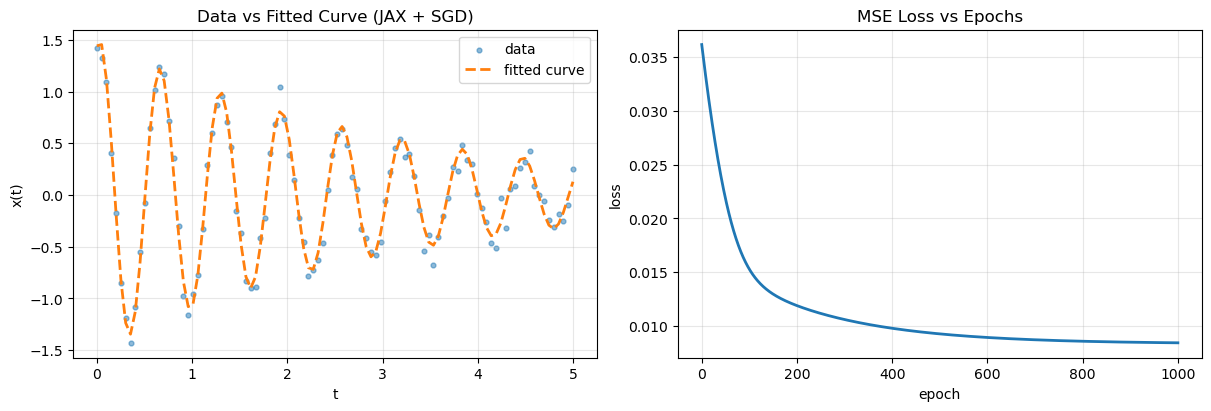

In [5]:
# 1.1 (single-layer NN for parameter inference using SGD in JAX)
# - N: number of noisy samples from the damped harmonic oscillator (batch size B = N)
# - times  ∈ R^{N}  # scalar input per sample (d_in = 1)
# - x_data ∈ R^{N}  # scalar target per sample (d_out = 1)
# Batched shapes are (N,) (1D vectors) instead of (N,1) = (B, d_in = d_out); this is fine here since d_in = d_out = 1.
num_samples = 100
time_end = 5.0
times  = np.linspace(0.0, time_end, num_samples)     
x_data = np.array([ 1.42136407e+00,  1.32538052e+00,  1.08997205e+00,  4.01375320e-01,
       -1.78495795e-01, -8.50696683e-01, -1.18615104e+00, -1.42918430e+00,
       -1.08653056e+00, -5.51030603e-01, -7.50736710e-02,  6.47062767e-01,
        1.01484947e+00,  1.23909135e+00,  1.16973363e+00,  7.14521669e-01,
        3.55287429e-01, -2.95169206e-01, -9.74425168e-01, -1.16492314e+00,
       -9.52631079e-01, -7.77656938e-01, -3.28057458e-01,  2.92744065e-01,
        6.01953380e-01,  8.65371671e-01,  9.54240091e-01,  7.08483475e-01,
        4.68455172e-01, -1.56245101e-01, -3.70602686e-01, -8.30733462e-01,
       -8.95167164e-01, -8.91137955e-01, -4.18014142e-01, -2.22376053e-01,
        4.10047775e-01,  6.88406843e-01,  1.04061990e+00,  7.30025281e-01,
        3.90618018e-01,  1.43181366e-01, -2.20778546e-01, -4.53298514e-01,
       -7.87562022e-01, -7.21285197e-01, -6.27664217e-01, -4.65873073e-01,
        4.76786963e-02,  3.89328316e-01,  5.92877625e-01,  6.37519856e-01,
        4.83785342e-01,  1.71821980e-01,  5.43082539e-02, -3.29509591e-01,
       -4.12974420e-01, -5.53475010e-01, -5.83206553e-01, -4.58252882e-01,
       -5.48980467e-02,  2.26195369e-01,  4.52451610e-01,  5.38430311e-01,
        3.67845822e-01,  3.97176254e-01,  1.84432283e-01, -1.49708735e-01,
       -5.37683940e-01, -3.88877197e-01, -6.79843289e-01, -4.05592818e-01,
       -2.06048677e-01, -3.04612159e-02,  2.73534969e-01,  2.33194682e-01,
        4.87619039e-01,  3.34767833e-01,  3.00019677e-01,  9.12268252e-03,
       -1.21252257e-01, -2.57336778e-01, -4.68953016e-01, -5.12673830e-01,
       -2.89839003e-02, -3.22855227e-01,  5.86021068e-02,  8.32512072e-02,
        2.60554538e-01,  3.23171785e-01,  4.29277758e-01,  8.75180664e-02,
       -1.17562189e-03, -5.57391100e-02, -2.43060644e-01, -3.07899430e-01,
       -1.78936431e-01, -2.53676100e-01, -9.54204646e-02,  2.55114941e-01], dtype=jnp.float32)

# single-layer parametric fit: f(t; θ) = a * exp(-β t) * cos(ω t - δ) = x̂
# learnable parameters: θ = (a, β, ω, δ) ∈ R^{4}  → stored as a 1D array of shape (4,)
def f(theta, t):
    a, beta, omega, delta = theta
    return a * jnp.exp(-beta*t) * jnp.cos(omega*t - delta)

def initial_parameters():
    return jnp.array([1.5, 0.5, 10.0, 0.5]) # reasonable initial guess for θ = (a, β, ω, δ)

# MSE loss over the full batch
def mse(theta, t, x):
    return jnp.mean((f(theta, t) - x)**2)

# One SGD step over the full batch 
@jax.jit
def sgd_step(theta, t, x, lr):
    loss, grads = jax.value_and_grad(mse)(theta, t, x)
    theta = theta - lr * grads
    return theta, loss

theta = initial_parameters()
lr = 1e-2
sgd_losses = []
num_epochs = 1000
epochs = jnp.arange(0, num_epochs + 1) # epochs = [0, 1, 2, ..., num_epochs]

for epoch in epochs:
    theta, loss = sgd_step(theta, times, x_data, lr)
    if epoch % (num_epochs // 5) == 0:
        print(f"At epoch = {epoch}, loss = {loss:.6f}")
    sgd_losses.append(loss)

fig, axs = plt.subplots(1,2, figsize = (12,4), constrained_layout=True)
x_fit = f(theta, times)

axs[0].scatter(times, x_data, s=12, alpha=0.5, label="data")
axs[0].set_title("Data vs Fitted Curve (JAX + SGD)")
axs[0].plot(times, x_fit, '--', color = 'C1', lw=2, label="fitted curve")
axs[0].set_xlabel("t")
axs[0].set_ylabel("x(t)")
axs[0].legend()
axs[0].grid(alpha=0.3)

axs[1].plot(epochs, sgd_losses, lw=2) 
axs[1].set_title("MSE Loss vs Epochs")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("loss")
axs[1].grid(alpha=0.3)

print(f"After training (JAX/SGD), the predicted theta is a = {theta[0]:.3f}, β = {theta[1]:.3f}, ω = {theta[2]:.3f}, δ = {theta[3]:.3f}")
'Note that the loss asymptotes to ~ 8e-3 (good fit) but does not reach 0 due to noise in the data (not an exact DHO signal).'

At epoch = 0, loss = 0.03618102893233299
At epoch = 200, loss = 0.008324611000716686
At epoch = 400, loss = 0.008324507623910904
At epoch = 600, loss = 0.00832446850836277
At epoch = 800, loss = 0.008324461057782173
At epoch = 1000, loss = 0.008324440568685532


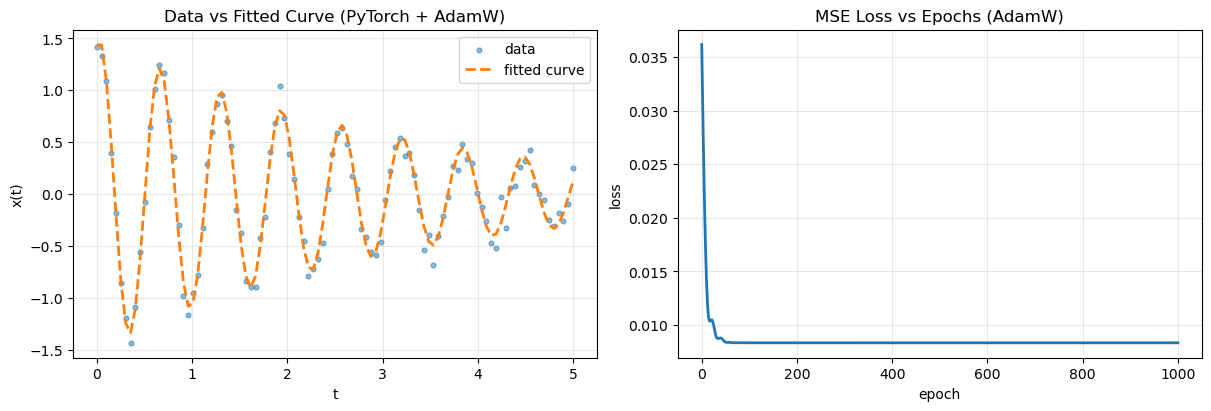

After training (Torch/AdamW), the predicted theta is a = 1.495, β = 0.315, ω = 9.873, δ = 0.272


'Note that the loss asymptotes to ~ 8e-3 much quicker than SGD due to AdamW optimizer.'

In [ ]:
# 1.2 (single-layer NN for parameter inference using ADAMW in PyTorch)
device = torch.device('mps' if torch.backends.mps.is_available() else "cpu") 
# convert data to PyTorch tensors
times_t = torch.as_tensor(times, dtype=torch.float32)
x_data_t = torch.as_tensor(x_data, dtype=torch.float32)

class ParameterInference(nn.Module): # pass 

    def __init__(self, theta_init):
        super().__init__() 
        theta_init = torch.as_tensor(theta_init, dtype=torch.float32)
        self.theta = nn.Parameter(theta_init)

    def forward(self, t):
        a, beta, omega, delta = self.theta
        return a * torch.exp(-beta*t) * torch.cos(omega*t - delta)

theta_init = initial_parameters()
net = ParameterInference(theta_init)

criterion = nn.MSELoss()
optimizer = optim.AdamW(net.parameters(), lr=1e-2, weight_decay=1e-2) # decoupled L2 regularization
adw_losses = []

for epoch in epochs:

    net.train()
    
    yhat = net(times_t)              
    loss = criterion(yhat, x_data_t)     

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()              

    if epoch % (num_epochs // 5) == 0:
        print(f"At epoch = {epoch}, loss = {loss.item()}")
    adw_losses.append(loss.item())

with torch.no_grad():
     # θ̂ = (a, β, ω, δ) as NumPy
    theta_hat = net.theta.detach().cpu().numpy()
    # fitted curve on same time grid
    x_fit_np = net(times_t).detach().cpu().numpy()
    t_plot = times_t.detach().cpu().numpy()

a_hat, beta_hat, omega_hat, delta_hat = theta_hat

fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

axs[0].scatter(t_plot, x_data, s=12, alpha=0.5, label="data")
axs[0].plot(t_plot, x_fit_np, '--', color='C1', lw=2, label="fitted curve")
axs[0].set_title("Data vs Fitted Curve (PyTorch + AdamW)")
axs[0].set_xlabel("t")
axs[0].set_ylabel("x(t)")
axs[0].legend()
axs[0].grid(alpha=0.3)

axs[1].plot(epochs, adw_losses, lw=2)
axs[1].set_title("MSE Loss vs Epochs (AdamW)")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("loss")
axs[1].grid(alpha=0.3)

plt.show()

print(f"After training (Torch/AdamW), the predicted theta is " f"a = {a_hat:.3f}, β = {beta_hat:.3f}, ω = {omega_hat:.3f}, δ = {delta_hat:.3f}")
'Note that the loss asymptotes to ~ 8e-3 much quicker than SGD due to AdamW optimizer.'

T =  3
<E>/N =  -0.76576
<E^2>/N =  0.6119296
<M>/N =  0.2261
<M^2>/N =  0.0839468
C= 0.0028379136000000007
chi= 0.010941863333333334
Acceptance ratio =  0.004763333333333333


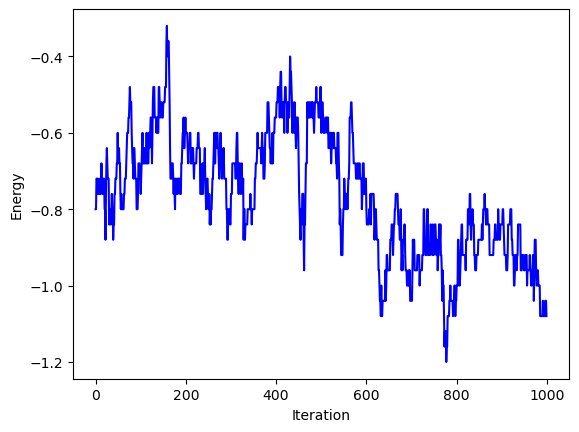

In [ ]:
# 2.1 (Monte Carlo samples from 2D Ising model)

# namespace for boundary conditions and directions (enumerations)
class BoundaryCondition:
    RBC, PBC = range(2) # RBC = 0, PBC = 1

class Direction:
    RIGHT, TOP, LEFT, BOTTOM = range(4) # Right = 0, Top = 1, Left = 2, Bottom = 3
    
class Ising(object):
    
    def __init__ (self, L, J, T):
      
        self.L = L
        self.N = L*L
        self.TWOJ = 2.*J
        self.T = T
        self.beta = 1./T
        
        # Initialize site positions
        # Initialize neighbors table for boundary conditions
        self.nn = np.zeros(shape=(self.N,4), dtype=np.int16)
        self.position = np.zeros(shape=(L,L), dtype=np.int16)
        self.x = np.zeros(self.N, dtype=np.int16)
        self.y = np.zeros(self.N, dtype=np.int16)

        # Periodic boundary conditions
        n = 0
        for iy in range(L):
            for ix in range(L):
                self.position[iy,ix] = n
                self.x[n] = ix
                self.y[n] = iy
                self.nn[n,Direction.LEFT] = n-1
                self.nn[n,Direction.RIGHT] = n+1
                self.nn[n,Direction.TOP] = n+L
                self.nn[n,Direction.BOTTOM] = n-L
                if(ix == 0):
                    self.nn[n,Direction.LEFT] = n+L-1
                if(ix == L-1):
                    self.nn[n,Direction.RIGHT] = n-(L-1)
                if(iy == 0):
                    self.nn[n, Direction.BOTTOM] = n+(L-1)*L
                if(iy == L-1):
                    self.nn[n, Direction.TOP] = n-(L-1)*L
                n += 1

        # Initialize spins
        r = np.random.random(self.N)*2-1
        self.spin = np.ones(self.N, dtype=np.int16)
        for i in range(self.N):
            if(r[i] < 0):
                self.spin[i] *= -1
                
        self.Mtot = np.sum(self.spin)
        self.E = 0.
        for i in range(self.N):
            self.E += -J*self.spin[i]*(self.spin[self.nn[i,Direction.RIGHT]]+self.spin[self.nn[i,Direction.TOP]])

        # Transition probabilities
        self.de = np.zeros(shape=(3,9)) # spins -1 and 1 only, but choose 3 to index as below. 9 = range of spin_sum, -4 . . . 4
        self.w = np.zeros(shape=(3,9))
        self.set_temp(self.T)
                                                             
    def set_temp(self, T):
        self.T = T
        self.beta = 1./T
        # Lookup tables for transition probabilities
        for spin_sum in range(-4,5):
            self.de[0,spin_sum+4] = -self.TWOJ*spin_sum
            self.de[2,spin_sum+4] = self.TWOJ*spin_sum
            p = np.exp(-self.beta*self.de[0,spin_sum+4])
            self.w[0,spin_sum+4] = min(p, 1.)
            self.w[2,spin_sum+4] = min(1./p,1.)
                                                             
    def metropolis(self):
        nchanges = 0
        if True: # for n in range(self.N):
            # trial spin change
            # pick a random particle
            i = int(np.random.random()*self.N)

            # change in energy
            iright = self.nn[i, Direction.LEFT]
            ileft = self.nn[i, Direction.RIGHT]
            itop = self.nn[i, Direction.TOP]
            ibottom = self.nn[i, Direction.BOTTOM]

            spin_sum = self.spin[ileft] + self.spin[iright] + self.spin[itop] + self.spin[ibottom]

            s = self.spin[i]
            deltaE = self.de[s+1,spin_sum+4]

            # accept if lowers energy or random num below w
            if(deltaE <= 0. or np.random.random() < self.w[s+1,spin_sum+4]):
                self.spin[i] *= -1
                self.Mtot += 2*(-s)
                self.E += deltaE
                nchanges += 1

        return nchanges

L=10
Nwarmup = 100
Nsteps = 1000
Ndecorr = 3
Temp = 3
J = 1.

S = Ising(L, J, Temp)
E = np.zeros(Nsteps)
M = np.zeros(Nsteps)

for i in range(Nwarmup):
    S.metropolis()

naccept = 0
for i in range(Nsteps):
    for n in range(Ndecorr):
        naccept += S.metropolis()
    E[i] = S.E
    M[i] = abs(S.Mtot)

E /= S.N
M /= S.N


Et = np.sum(E)/Nsteps
E2t = np.sum(E**2)/Nsteps
Mt = np.sum(M)/Nsteps
M2t = np.sum(M**2)/Nsteps

print("T = ", Temp)
print("<E>/N = ", Et)
print("<E^2>/N = ", E2t)
print("<M>/N = ", Mt)
print("<M^2>/N = ", M2t)
print("C=", (E2t-Et*Et)/Temp/Temp)
print("chi=", (M2t-Mt*Mt)/Temp)
print("Acceptance ratio = ", float(naccept)/S.N/Nsteps/Ndecorr)
        
plt.plot(np.arange(0,Nsteps,1),E,ls='-',c='blue');
plt.xlabel("Iteration")
plt.ylabel("Energy");     


In [ ]:
# 2.2 (CNN to classify samples as ordered or disordered)


In [ ]:
# 2.3 ()